<a href="https://colab.research.google.com/github/ihsu1/EEGEmotionRecognition/blob/main/emotion_eeg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# imports

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import tensorflow as tf
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau


sns.set(style='white', context='notebook', palette='deep')

In [59]:
from google.colab import drive

drive.mount('/content/drive')
path = "/content/drive/MyDrive/data/emotions.csv"
df = pd.read_csv(path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [60]:
df.head

<bound method NDFrame.head of       # mean_0_a  mean_1_a  mean_2_a  mean_3_a  mean_4_a  mean_d_0_a  \
0          4.620      30.3    -356.0     15.60      26.3       1.070   
1         28.800      33.1      32.0     25.80      22.8       6.550   
2          8.900      29.4    -416.0     16.70      23.7      79.900   
3         14.900      31.6    -143.0     19.80      24.3      -0.584   
4         28.300      31.3      45.2     27.30      24.5      34.800   
...          ...       ...       ...       ...       ...         ...   
2127      32.400      32.2      32.2     30.80      23.4       1.640   
2128      16.300      31.3    -284.0     14.30      23.9       4.200   
2129      -0.547      28.3    -259.0     15.80      26.7       9.080   
2130      16.800      19.9    -288.0      8.34      26.0       2.460   
2131      27.000      32.0      31.8     25.00      28.9       4.990   

      mean_d_1_a  mean_d_2_a  mean_d_3_a  mean_d_4_a  ...  fft_741_b  \
0          0.411     -15.700       2.060        3.15  ...      23.50   
1          1.680       2.880       3.830       -4.82  ...     -23.30   
2          3.360      90.200      89.900        2.03  ...     462.00   
3         -0.284       8.820       2.300       -1.97  ...     299.00   
4         -5.790       3.060      41.400        5.52  ...      12.00   
...          ...         ...         ...         ...  ...        ...   
2127      -2.030       0.647      -0.121       -1.10  ...     -21.70   
2128       1.090       4.460       4.720        6.63  ...     594.00   
2129       6.900      12.700       2.030        4.64  ...     370.00   
2130       1.580     -16.000       1.690        4.74  ...     124.00   
2131       1.950       6.210       3.490       -3.51  ...       1.95   

      fft_742_b  fft_743_b  fft_744_b  fft_745_b  fft_746_b  fft_747_b  \
0        20.300     20.300      23.50     -215.0     280.00    -162.00   
1       -21.800    -21.800     -23.30      182.0       2.57     -31.60   
2      -233.000   -233.000     462.00     -267.0     281.00    -148.00   
3      -243.000   -243.000     299.00      132.0     -12.40       9.53   
4        38.100     38.100      12.00      119.0     -17.60      23.90   
...         ...        ...        ...        ...        ...        ...   
2127      0.218      0.218     -21.70       95.2     -19.90      47.20   
2128   -324.000   -324.000     594.00      -35.5     142.00     -59.80   
2129   -160.000   -160.000     370.00      408.0    -169.00     -10.50   
2130    -27.600    -27.600     124.00     -656.0     552.00    -271.00   
2131      1.810      1.810       1.95      110.0      -6.71      22.80   

      fft_748_b  fft_749_b     label  
0       -162.00     280.00  NEGATIVE  
1        -31.60       2.57   NEUTRAL  
2       -148.00     281.00  POSITIVE  
3          9.53     -12.40  POSITIVE  
4         23.90     -17.60   NEUTRAL  
...         ...        ...       ...  
2127      47.20     -19.90   NEUTRAL  
2128     -59.80     142.00  POSITIVE  
2129     -10.50    -169.00  NEGATIVE  
2130    -271.00     552.00  NEGATIVE  
2131      22.80      -6.71   NEUTRAL  

[2132 rows x 2549 columns]>

# exploratory data analysis

In [61]:
df.isnull().sum() # no null

,0
# mean_0_a,0
mean_1_a,0
mean_2_a,0
mean_3_a,0
mean_4_a,0
...,...
fft_746_b,0
fft_747_b,0
fft_748_b,0
fft_749_b,0


In [62]:
df.describe()

,# mean_0_a,mean_1_a,mean_2_a,mean_3_a,mean_4_a,mean_d_0_a,mean_d_1_a,mean_d_2_a,mean_d_3_a,mean_d_4_a,...,fft_740_b,fft_741_b,fft_742_b,fft_743_b,fft_744_b,fft_745_b,fft_746_b,fft_747_b,fft_748_b,fft_749_b
count,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,...,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000,2132.000000
mean,15.256914,27.012462,-104.975629,13.605898,24.150483,0.025378,0.052282,0.301655,0.036793,0.083567,...,-22.938971,104.946111,-51.973647,-51.973647,104.946111,-6.934144,95.104886,-49.061255,-49.061255,95.104886
std,15.284621,9.265141,206.271960,16.874676,14.187340,17.981796,8.509174,68.098894,17.010031,18.935378,...,298.034311,212.532721,112.160233,112.160233,212.532721,281.040552,203.194976,106.486317,106.486317,203.194976
min,-61.300000,-114.000000,-970.000000,-137.000000,-217.000000,-218.000000,-255.000000,-1360.000000,-203.000000,-553.000000,...,-1180.000000,-921.000000,-504.000000,-504.000000,-921.000000,-1160.000000,-1010.000000,-521.000000,-521.000000,-1010.000000
25%,6.577500,26.075000,-195.000000,4.857500,23.600000,-3.105000,-1.340000,-4.002500,-2.905000,-2.622500,...,-106.500000,-8.365000,-92.900000,-92.900000,-8.365000,-102.500000,-8.837500,-87.150000,-87.150000,-8.837500
50%,14.100000,30.000000,14.950000,15.400000,25.200000,-0.044600,0.132000,0.957500,-0.099750,0.146500,...,83.850000,12.150000,-21.800000,-21.800000,12.150000,89.700000,13.400000,-24.100000,-24.100000,13.400000
75%,27.700000,31.400000,29.600000,26.500000,26.800000,2.920000,1.540000,6.735000,2.535000,2.870000,...,154.000000,177.000000,12.025000,12.025000,177.000000,153.000000,149.250000,10.925000,10.925000,149.250000
max,304.000000,42.300000,661.000000,206.000000,213.000000,402.000000,257.000000,1150.000000,349.000000,444.000000,...,1070.000000,843.000000,1490.000000,1490.000000,843.000000,1180.000000,888.000000,1670.000000,1670.000000,888.000000


In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2132 entries, 0 to 2131
Columns: 2549 entries, # mean_0_a to label
dtypes: float64(2548), object(1)
memory usage: 41.5+ MB


In [64]:
df['label'].value_counts()

,count
label,
NEUTRAL,716
NEGATIVE,708
POSITIVE,708


In [65]:
labels = df["label"]

# df_copy = df.copy()
df['label'] = df['label'].replace('NEGATIVE', 0)
df['label'] = df['label'].replace('NEUTRAL', 1)
df['label'] = df['label'].replace('POSITIVE', 2)

<ipython-input-65-9ae493581ea8>:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['label'] = df['label'].replace('POSITIVE', 2)


Visualizing (googled)

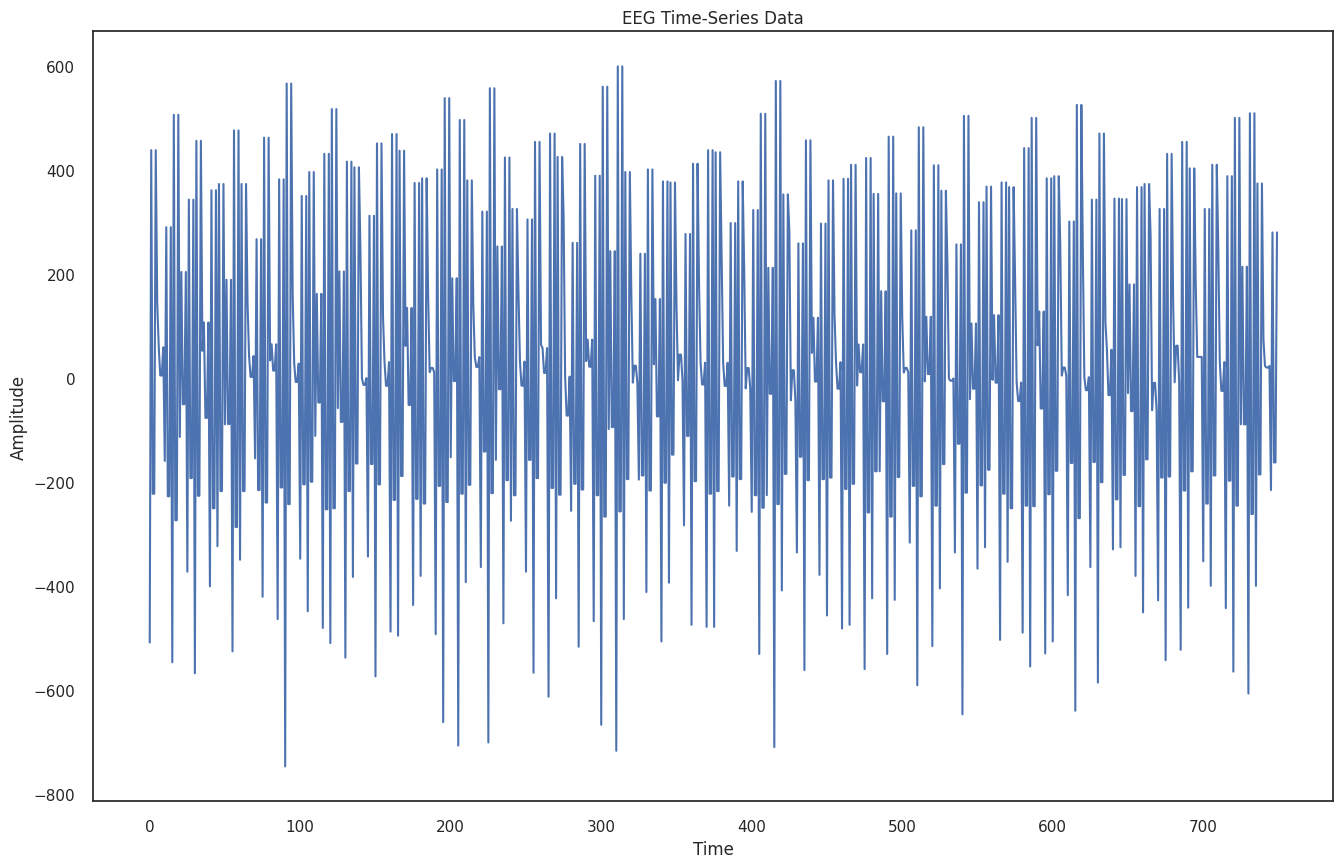

In [66]:
# Time-Series Visualization
sample = df.loc[0, 'fft_0_b':'fft_749_b']
plt.figure(figsize=(16, 10))
plt.plot(range(len(sample)), sample)
plt.title("EEG Time-Series Data")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

In [67]:
#Separating Positive,Neagtive and Neutral dataframes for plotting
pos = df.loc[df["label"]==2]
sample_pos = pos.loc[2, 'fft_0_b':'fft_749_b']
neg = df.loc[df["label"]==0]
sample_neg = neg.loc[0, 'fft_0_b':'fft_749_b']
neu = df.loc[df["label"]==1]
sample_neu = neu.loc[1, 'fft_0_b':'fft_749_b']

<ipython-input-68-cbf03869dc82>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


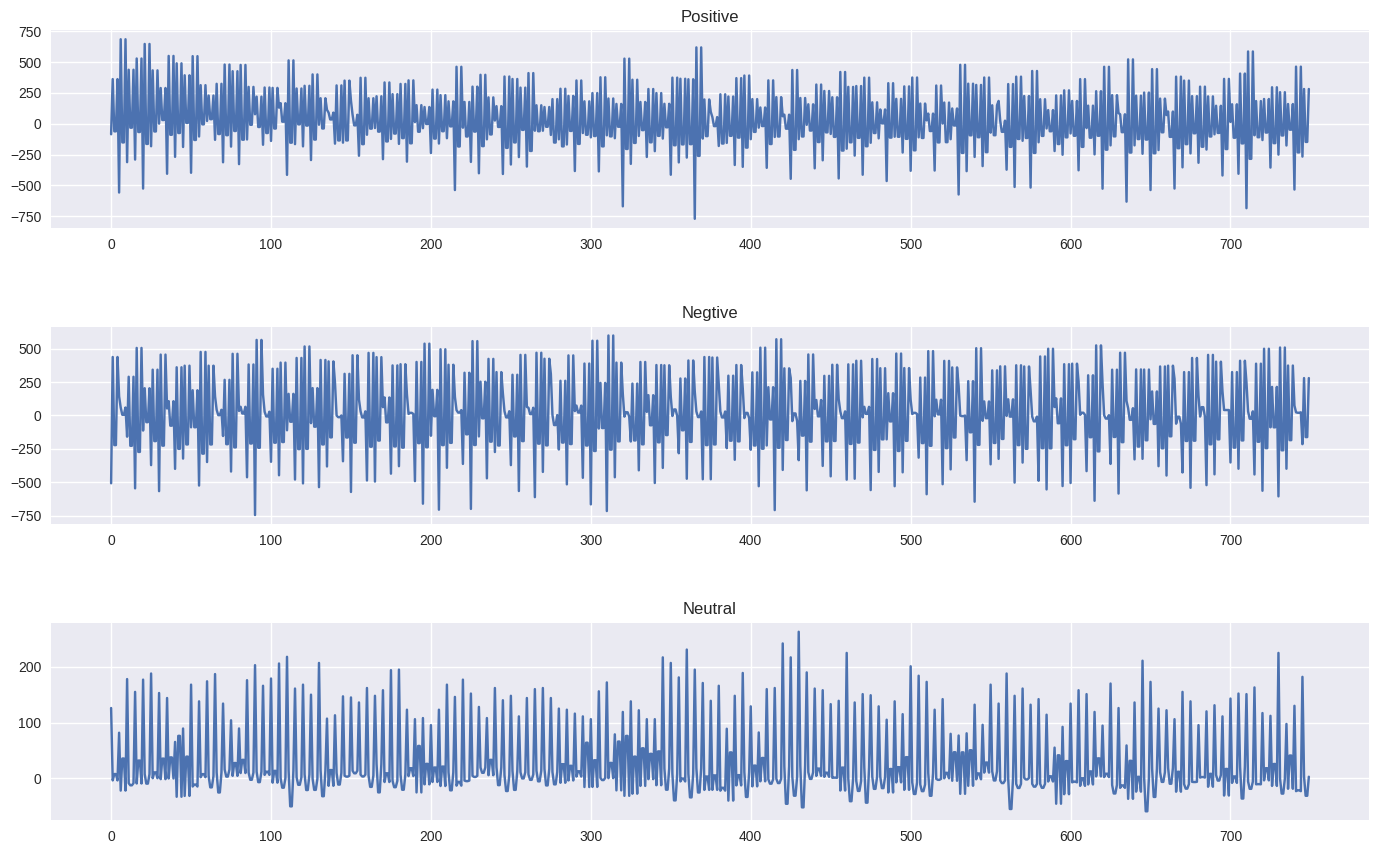

In [68]:
plt.style.use('seaborn')
fig, axs = plt.subplots(3, figsize=(17, 10))
fig.subplots_adjust(top=0.9, hspace=0.5)  # Ajustement de l'espacement
axs[0].plot(range(len(sample_pos)), sample_pos)
axs[0].set_title('Positive')
axs[1].plot(range(len(sample_neg)), sample_neg)
axs[1].set_title('Negtive')
axs[2].plot(range(len(sample_neu)), sample_neu)
axs[2].set_title('Neutral')
plt.show()

# train/test split

In [69]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# data = pd.DataFrame(scaler.fit_transform(df))
df.iloc[:, :-1] = scaler.fit_transform(df.iloc[:, :-1])

In [70]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2)

In [71]:
ytrain = train["label"]
xtrain = train.drop(labels = ["label"],axis = 1)

In [72]:
ytest = test["label"]
xtest = test.drop(labels = ["label"],axis = 1)

# model

MLP (based on paper parameters) ~ 94.61% accuracy

In [73]:
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import accuracy_score

In [74]:
mlp = MLPClassifier(hidden_layer_sizes=(30, 20), max_iter=500, solver='adam', random_state=0, tol=0.0001, learning_rate_init=0.0001, early_stopping=True)

In [75]:
# Training the model
mlp.fit(xtrain, ytrain)

# Predicting on testing set
y_pred = mlp.predict(xtest)

# Calculating accuracy
accuracy = accuracy_score(ytest, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 94.61%


Neural Network ~ 98% accuracy

In [76]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(xtrain.shape[1],)),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [77]:
# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [78]:
# Train the model
history = model.fit(xtrain, ytrain, validation_split=0.2, epochs=400, batch_size=32, verbose=2)

Epoch 1/400
43/43 - 2s - 45ms/step - accuracy: 0.7683 - loss: 1.3330 - val_accuracy: 0.8974 - val_loss: 0.3788
Epoch 2/400
43/43 - 1s - 12ms/step - accuracy: 0.8482 - loss: 0.6853 - val_accuracy: 0.9003 - val_loss: 0.4662
Epoch 3/400
43/43 - 1s - 15ms/step - accuracy: 0.8695 - loss: 0.5507 - val_accuracy: 0.9267 - val_loss: 0.2969
Epoch 4/400
43/43 - 1s - 22ms/step - accuracy: 0.8966 - loss: 0.3918 - val_accuracy: 0.9150 - val_loss: 0.5113
Epoch 5/400
43/43 - 1s - 26ms/step - accuracy: 0.8988 - loss: 0.5657 - val_accuracy: 0.9179 - val_loss: 0.3081
Epoch 6/400
43/43 - 1s - 29ms/step - accuracy: 0.9150 - loss: 0.2846 - val_accuracy: 0.9355 - val_loss: 0.2922
Epoch 7/400
43/43 - 1s - 26ms/step - accuracy: 0.9282 - loss: 0.2318 - val_accuracy: 0.9150 - val_loss: 0.2573
Epoch 8/400
43/43 - 1s - 12ms/step - accuracy: 0.9186 - loss: 0.2434 - val_accuracy: 0.9355 - val_loss: 0.2610
Epoch 9/400
43/43 - 1s - 15ms/step - accuracy: 0.9304 - loss: 0.2182 - val_accuracy: 0.9296 - val_loss: 0.2553
E

# evaluating model

In [79]:
ypred = np.argmax(model.predict(xtest), axis=-1)

accuracy = accuracy_score(ytest, ypred)
print(f"Accuracy: {accuracy * 100:.2f}%")

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Accuracy: 97.89%


In [80]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

In [81]:
cm = confusion_matrix(ytest, ypred)
clr = classification_report(ytest, ypred, target_names={"Negative","Neutral","Positive"})

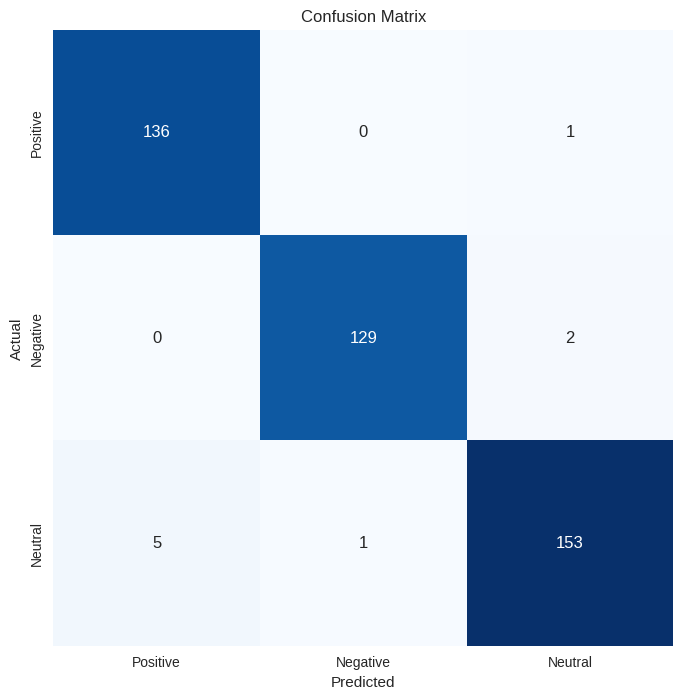

In [82]:
# Visualization of Confusion Matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels={"Negative","Neutral","Positive"}, yticklabels={"Negative","Neutral","Positive"})
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [83]:
# Print Classification Report
print("Classification Report:\n", clr)

Classification Report:
               precision    recall  f1-score   support

    Positive       0.96      0.99      0.98       137
    Negative       0.99      0.98      0.99       131
     Neutral       0.98      0.96      0.97       159

    accuracy                           0.98       427
   macro avg       0.98      0.98      0.98       427
weighted avg       0.98      0.98      0.98       427

